# **Problem Statement**
The problem is preety much stright forward, we all are famelier with Garbage and waste material which is very harmful for our society.if we talk about amount of waste then the world almost generates at least 5 million tons of waste per day and this number is still increasing day by day that's why we need to aware about waste. This model which help us to classify waste with 2 different waste materials and it will show you the details of that particular waste materials. This will help to raise awareness for people to reduce and recycle waste.
## **Overview**
- There are <b> Recycle and Non-recycle</b> total 2 different types of waste materials which are use for recycling.
- Here I have training for 1010 images and testing for 250 belonging 2 classes.
- Here I have trained dataset using pretrained VGG16 model via using Transfer Learning and Fine Tuning technique for classification.
- Here I will train this model till 15 epochs with apply early stoping and we got  Test accuracy: 0.8467742204666138 accuracy.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import sklearn
import tensorflow as tf
from tensorflow import keras
from PIL import Image as im
from glob import glob
from sklearn.model_selection import train_test_split
import keras
#from tf.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## **Train Datasets Collection & Understanding**

In [ ]:
train_path = '/content/drive/MyDrive/Recycle or Non-recycle/train'

Shape: (1010, 224, 224, 3), Labels: (1010,)


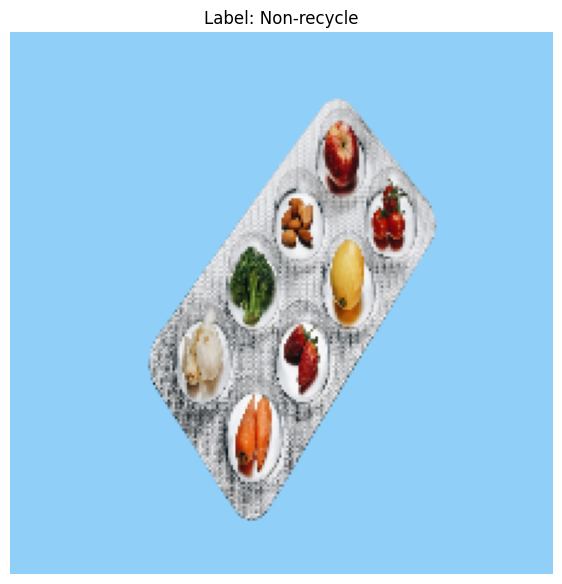

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup Class Names
class_names = sorted(os.listdir(train_path))
label_mapping = {name: i for i, name in enumerate(class_names)}

train_data = []
train_labels = []

# 2. Loop through folders
for i in os.listdir(train_path):
    dir = os.path.join(train_path, i) # os.path.join is safer than string concatenation

    for j in os.listdir(dir):
        img_path = os.path.join(dir, j)

        # Read image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)

        if img is None:
            print(f"Warning: Could not read image {img_path}. Skipping.")
            continue

        # --- FIX STARTS HERE ---
        # Convert from BGR (OpenCV default) to RGB (Standard for ML and Matplotlib)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize using INTER_LINEAR (smoother) or INTER_AREA (better for shrinking)
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
        # --- FIX ENDS HERE ---

        train_data.append(img)
        train_labels.append(label_mapping[i])

# 3. Convert to Arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)

print(f"Shape: {train_data.shape}, Labels: {train_labels.shape}")

# 4. Visualize to verify
plt.figure(figsize=(7, 10))
plt.axis('off')
plt.title(f"Label: {class_names[train_labels[-1]]}") # Shows the class name of the last image
plt.imshow(train_data[-1]) # Plots the last image processed
plt.show()

## Training Datas Labels

In [ ]:
# Show the data classes
classes = os.listdir(train_path)
classes

['Recycle', 'Non-recycle']

### **Test Datasets Collection & Understanding**

In [ ]:
test_path = '/content/drive/MyDrive/Recycle or Non-recycle/test'

In [ ]:
import os
import cv2
import numpy as np

test_data = []
test_labels = []

# RENAMED: 'dict' changed to 'label_map' to avoid conflict with Python keyword
label_map = {"Non-recycle": 0, "Recycle": 1}

for class_name in os.listdir(test_path):
    class_dir = os.path.join(test_path, class_name)

    # Skip if not a directory (good safety check)
    if not os.path.isdir(class_dir):
        continue

    for filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, filename)

        # Read image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)

        if img is None:
            print(" Cannot read file:", img_path)
            continue

        # --- FIX 1: Match the Color Space of Training Data ---
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # --- FIX 2: Match the Resize Quality of Training Data ---
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)

        test_data.append(img)
        # Access the correct label from the map
        test_labels.append(label_map[class_name])

# Convert to numpy arrays
test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Final shape:")
print(test_data.shape, test_labels.shape)

 Cannot read file: /content/drive/MyDrive/Recycle or Non-recycle/test/Recycle/Copy of Copy of 5_Dimensions-Objects-Beverage-Containers-Soda-Bottle-2-Liter-Size-Comparison.svg
 Cannot read file: /content/drive/MyDrive/Recycle or Non-recycle/test/Recycle/Copy of 5_Dimensions-Objects-Beverage-Containers-Soda-Bottle-2-Liter-Size-Comparison.svg
Final shape:
(250, 224, 224, 3) (250,)


### **Data Augmentation part done on training Dataset**

In [ ]:
# this is the augmentation configuration we will use for training
# It generate more images using below parameters
training_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

# this is a generator that will read pictures found in
# at train_data_path, and indefinitely generate
# batches of augmented image data
training_data = training_datagen.flow_from_directory(train_path, # this is the target directory means give train directory path
                                      target_size=(224, 224), # all images will be resized to 224x224
                                      batch_size=32,
                                      class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

Found 1002 images belonging to 2 classes.


In [ ]:
# show augmented images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### **Data Augmentation Visualization**

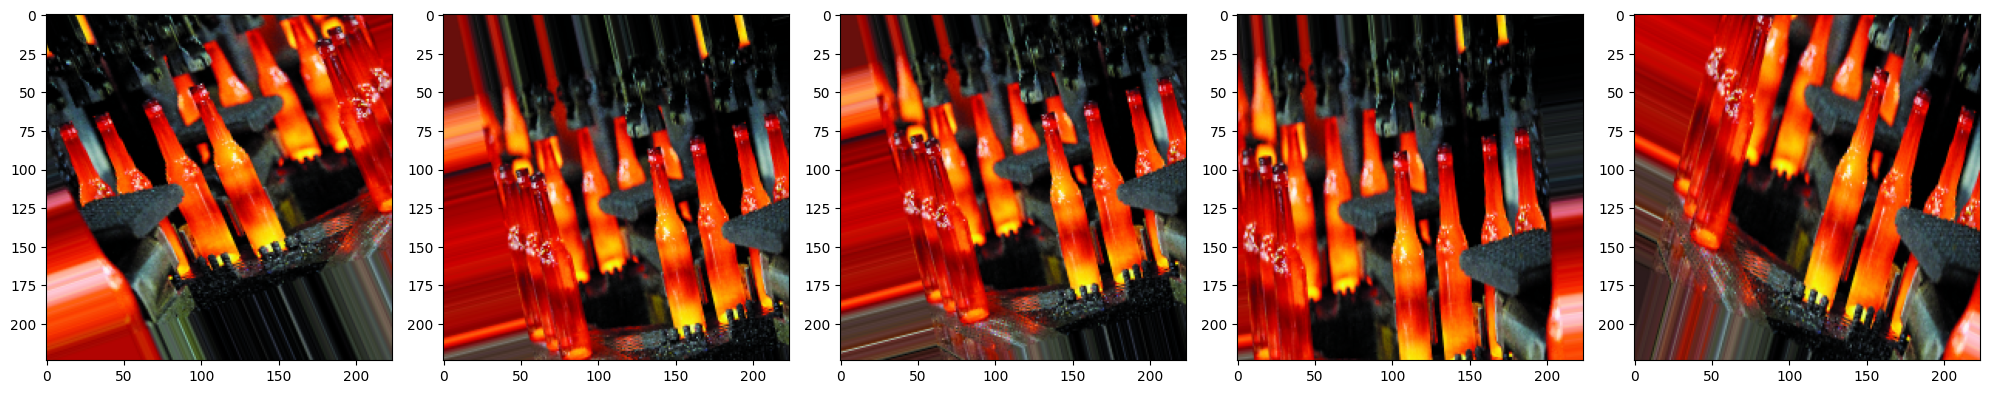

In [ ]:
# showing augmented images
images = [training_data[0][0][0] for i in range(5)]
plotImages(images)

Text(0, 0.5, 'Number of Traingn images')

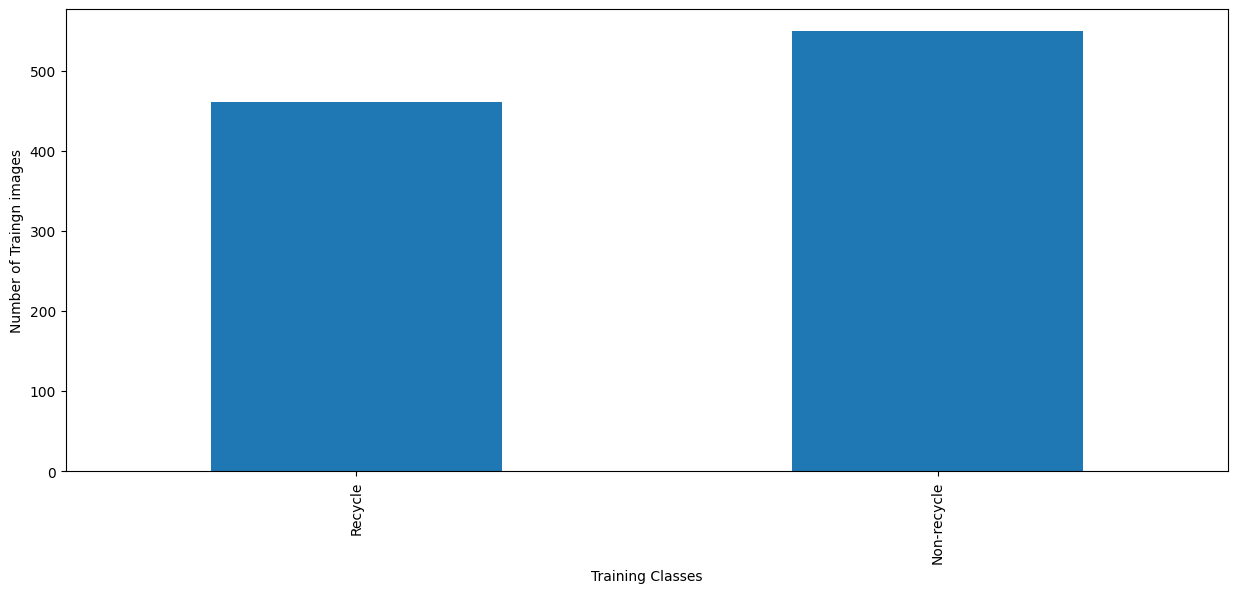

In [ ]:
# number of images in each class for training datasets
data_dic = {}
for folder in os.listdir(train_path):
    data_dic[folder] = len(os.listdir(train_path + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Training Classes')
plt.ylabel('Number of Traingn images')

### **Data Augmentation part done on Testing Dataset**

In [ ]:
# this is the augmentation configuration we will use for training
# It generate more images using below parameters
testing_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# at train_data_path, and indefinitely generate
# batches of augmented image data
testing_data = testing_datagen.flow_from_directory(test_path, # this is the target directory means give train directory path
                                      target_size=(224, 224), # all images will be resized to 224x224
                                      batch_size=32,
                                      class_mode='binary',
                                      shuffle = False)  # since we use binary_crossentropy loss, we need binary labels

Found 248 images belonging to 2 classes.


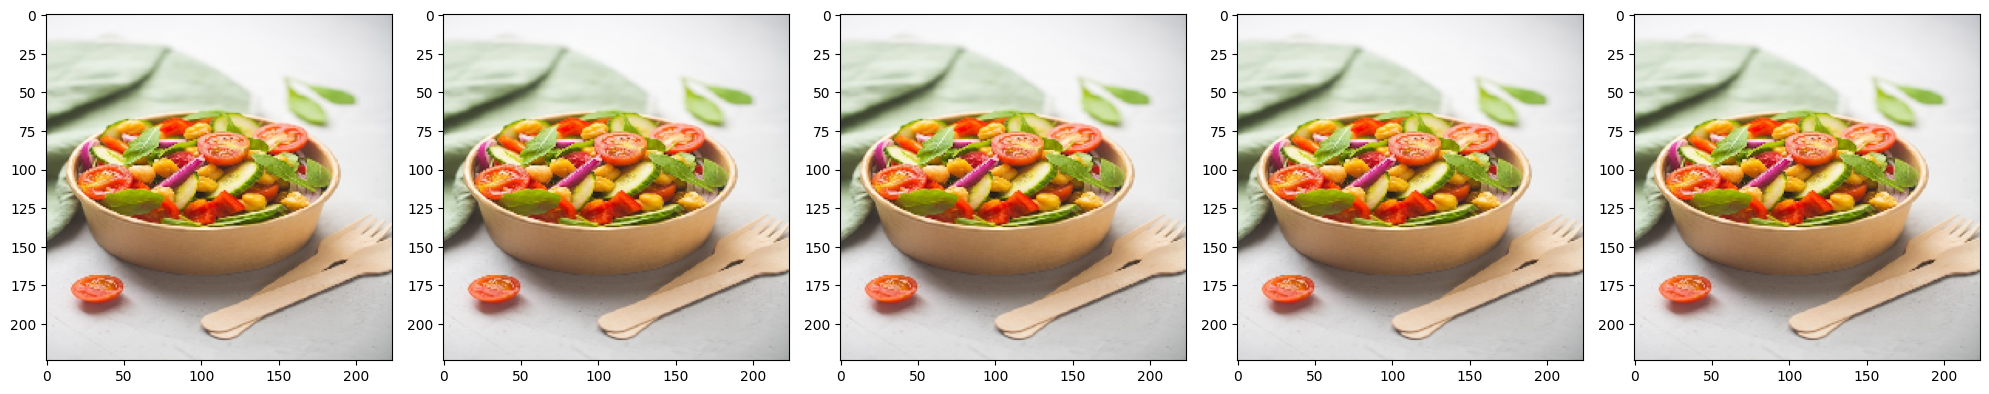

In [ ]:
# showing augmented images
images = [testing_data[1][0][0] for i in range(5)]
plotImages(images)

Text(0, 0.5, 'Number of Validation images')

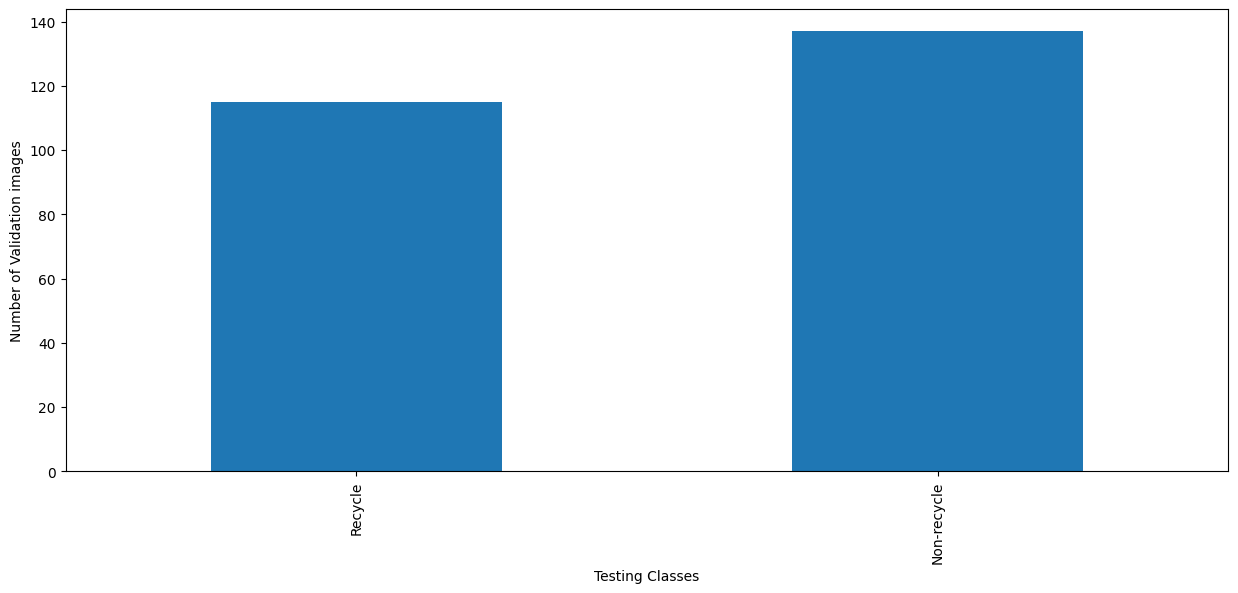

In [ ]:

# number of images in each class for training datasets
data_dic = {}
for folder in os.listdir(test_path):
    data_dic[folder] = len(os.listdir(test_path + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Testing Classes')
plt.ylabel('Number of Validation images')

## **CNN - VGG16 Architeture using Tranfer Learning**

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
'''
# Import label encoder
from sklearn import preprocessing
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
'''

#from tensorflow.keras.utils import to_categorical

'\n# Import label encoder\nfrom sklearn import preprocessing\n# label_encoder object knows how to understand word labels.\nlabel_encoder = preprocessing.LabelEncoder()\n'

In [ ]:
train_labels.shape

(1010,)

In [ ]:
# We build the base model
base_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# We freeze every layer in our base model so that they do not train, we want that our feature extractor stays as before --> transfer learning
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
model = Sequential()
model.add(base_model)        # The pre-trained engine
model.add(Flatten())         # The connector
model.add(Dense(1, activation='sigmoid')) # The driver (your binary classifier)

In [ ]:
model.summary() # Tranfer Learning Summary

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# We compile the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])



In [ ]:
history = model.fit(
    training_data,           # Your training generator
    validation_data=testing_data, # Your test/validation generator
    epochs=10,               # How many times to go through the entire dataset
    steps_per_epoch=len(training_data), # (Optional) Explicitly tells Keras how many batches are in one epoch
    validation_steps=len(testing_data))  # (Optional) Explicitly tells Keras how many batches to check for validation


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 7/32 ━━━━━━━━━━━━━━━━━━━━ 16s 678ms/step - accuracy: 0.6760 - loss: 0.6328

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.7310 - loss: 0.5428 - val_accuracy: 0.7661 - val_loss: 0.5753
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8591 - loss: 0.3191 - val_accuracy: 0.7500 - val_loss: 0.6031
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8702 - loss: 0.2835 - val_accuracy: 0.7984 - val_loss: 0.5622
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8991 - loss: 0.2530 - val_accuracy: 0.7823 - val_loss: 0.5408
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9184 - loss: 0.1927 - val_accuracy: 0.8024 - val_loss: 0.5401
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9283 - loss: 0.1951 - val_accuracy: 0.7782 - val_loss: 0.5526
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9452 - loss: 0.1754 - val_accuracy: 0.7782 - val_loss: 0.5649
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9295 - loss: 0.1891 - val_accuracy: 0.7984 - val_loss: 0.5502
Epo

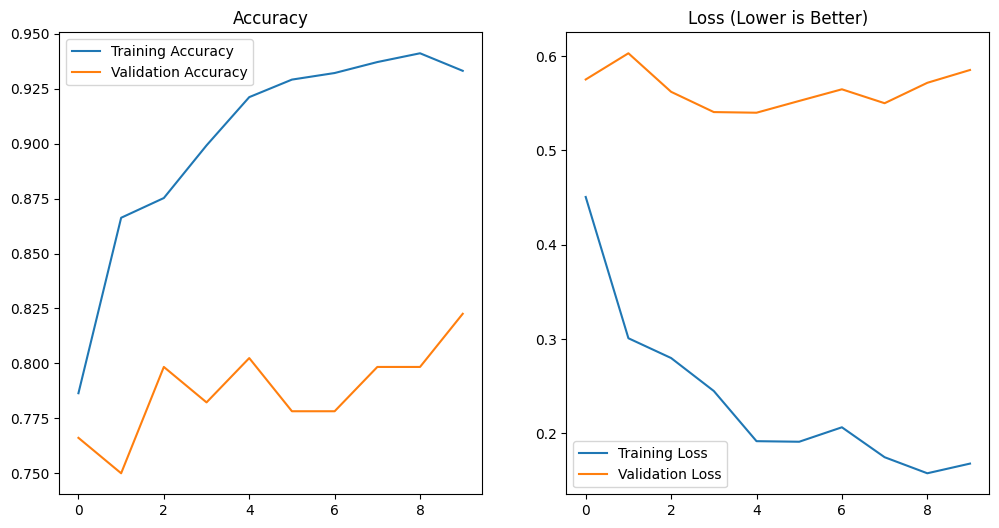

In [ ]:
import matplotlib.pyplot as plt

# 1. Plot the accuracy (Train vs Test)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# 2. Plot the Loss (Train vs Test)
# This will show you exactly where the lines crossed and started getting worse
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss (Lower is Better)')
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 860ms/step


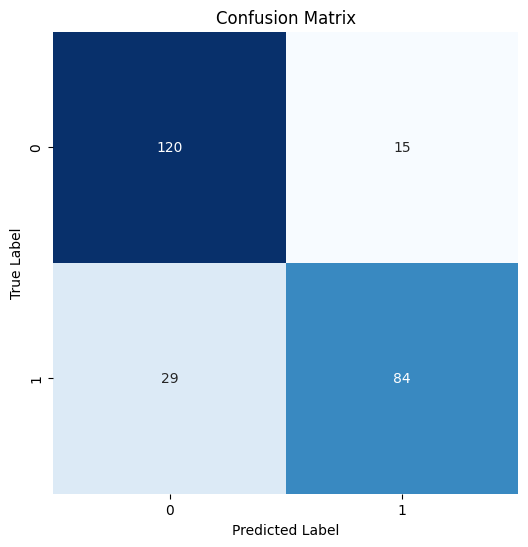

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       135
           1       0.85      0.74      0.79       113

    accuracy                           0.82       248
   macro avg       0.83      0.82      0.82       248
weighted avg       0.83      0.82      0.82       248



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# 1. Get the predictions
# We need to reset the validation generator so it starts from the first image
testing_data.reset()

# Predict raw probabilities (e.g., 0.12, 0.95, 0.88)
predictions = model.predict(testing_data, steps=len(testing_data), verbose=1)

# 2. Convert probabilities to class (0 or 1)
# Since it's binary, if probability > 0.5, it's class 1 (Dog), else class 0 (Cat)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)

# 3. Get the true labels
true_classes = testing_data.classes

# 4. Create the Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# 5. Plot it nicely
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 6. Print the detailed report
print(classification_report(true_classes, predicted_classes))

In [ ]:
# We evaluate the accuracy and the loss in the test set
scores = model.evaluate(testing_data, steps = len(testing_data), verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 716ms/step - accuracy: 0.8428 - loss: 0.5197
Test loss: 0.5854113101959229
Test accuracy: 0.8225806355476379


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 1. Setup Callbacks
checkpointer = ModelCheckpoint(filepath='vgg16_model.weights.best.keras',
                               verbose=1,
                               save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=4,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
y_pred = model.predict(testing_data)
prediction = (y_pred > 0.5).astype("int32")

print("Unique values found:", np.unique(prediction))

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 731ms/step
Unique values found: [0 1]


In [ ]:
y_pred

array([[7.9980135e-02],
       [2.1934903e-01],
       [5.4486617e-03],
       [9.9918944e-01],
       [8.2708657e-01],
       [1.5234940e-04],
       [8.6298448e-01],
       [7.6606357e-04],
       [7.6792486e-02],
       [8.0139644e-02],
       [7.9980135e-02],
       [2.1934903e-01],
       [5.4486617e-03],
       [9.9918944e-01],
       [1.5234940e-04],
       [8.6298448e-01],
       [7.6606357e-04],
       [7.6792486e-02],
       [8.0139644e-02],
       [5.9739050e-06],
       [4.8566799e-04],
       [9.9254477e-01],
       [1.8945382e-03],
       [4.2281041e-04],
       [9.1937870e-01],
       [1.2023359e-02],
       [1.2515649e-01],
       [2.6460633e-02],
       [5.3364304e-03],
       [7.5122184e-04],
       [2.5810570e-01],
       [1.6927890e-02],
       [2.2188481e-02],
       [2.4266222e-03],
       [5.9739050e-06],
       [9.9254477e-01],
       [4.8516065e-01],
       [4.4456217e-02],
       [1.1719487e-03],
       [3.2393247e-05],
       [2.0542762e-01],
       [1.080723

In [ ]:
prediction

array([[0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


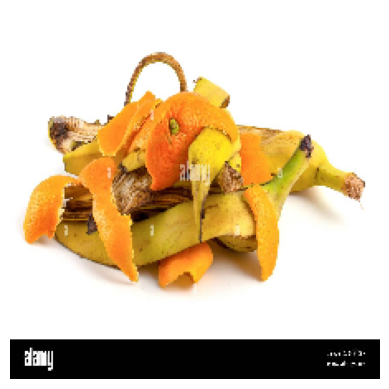

Raw Score: 0.3324
PREDICTION: NON-RECYCLE (66.76%)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_image(image_path, model):
    # 1. Load the image and resize it to 224x224 (Model expectation)
    img = image.load_img(image_path, target_size=(224, 224))

    # 2. Convert to Array and Normalize (1./255)
    # Important: We must match the rescale=1./255 we did in training!
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0

    # 3. Add the Batch Dimension
    # The model expects shape (1, 224, 224, 3), not just (224, 224, 3)
    img_batch = np.expand_dims(img_array, axis=0)

    # 4. Make Prediction
    prediction = model.predict(img_batch)
    score = prediction[0][0]  # Get the single number out

    # 5. Show the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # 6. Interpret Result
    # NOTE: Adjust these labels based on your Step 1 print output!
    # Assuming 0 = Non-Recycle, 1 = Recycle
    print(f"Raw Score: {score:.4f}")

    if score > 0.5:
        print(f"PREDICTION: RECYCLE ({score:.2%})")
    else:
        print(f"PREDICTION: NON-RECYCLE ({(1-score):.2%})")

# --- HOW TO RUN ---
# Replace this string with the path to a test image on your computer
test_image_path = '/content/drive/MyDrive/Testing-photos/banana.jpg'

# Run the function
predict_image(test_image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


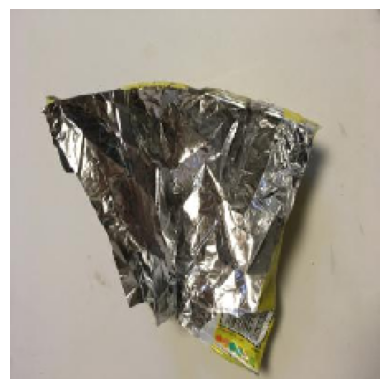

Raw Score: 0.0440
PREDICTION: NON-RECYCLE (95.60%)


In [ ]:
# Replace this string with the path to a test image on your computer
test_image_path = '/content/drive/MyDrive/Testing-photos/trash112.jpg'

# Run the function
predict_image(test_image_path, model)

In [ ]:
rev_dict = {
    0 : 'Non-recycle',
    1 :'Recycle',
}

In [ ]:
rev_dict.values()

dict_values(['Non-recycle', 'Recycle'])

In [ ]:
y_hat_pred = []

# We flatten the array first so it becomes a simple list of numbers [0, 1, 0...]
# instead of a list of lists [[0], [1], [0]...]
flat_predictions = prediction.flatten()

for i in flat_predictions:
    y_hat_pred.append(rev_dict[i])

# Now check the first few results
print(y_hat_pred[:5])

['Non-recycle', 'Non-recycle', 'Non-recycle', 'Recycle', 'Recycle']


# Apply Fine-tuning on VGG16

In [ ]:
# We allow to the last convolutional andthe classification stages  to train
from tensorflow.keras.optimizers import Adam

# 1. Get the VGG16 base from your existing model
# Note: Assuming 'base_model' is the first layer of your Sequential model
base_model = model.layers[0]

# 2. Unfreeze the whole base first
base_model.trainable = True

# 3. Re-freeze everything EXCEPT the last block (Block 5)
# We want to keep the first 15 layers (Lines/Shapes) frozen
# We want to train the last 4 layers (Complex Textures)
for layer in base_model.layers:
    if layer.name.startswith('block5'):
        layer.trainable = True
    else:
        layer.trainable = False

# Verify it worked (You should see some Trainable, some Non-trainable)
for layer in base_model.layers:
    print(f"{layer.name}: {layer.trainable}")

# 4. Re-compile with a TINY Learning Rate
# This is the secret sauce. Low LR = Gentle updates.
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # 0.00001
    loss='binary_crossentropy',          # Keep Binary!
    metrics=['accuracy']
)

# 5. Continue Training (Fine-Tuning)
history_fine = model.fit(
    training_data,
    validation_data=testing_data,
    epochs=10, # Add 10 more epochs
    callbacks=[early_stop, checkpointer] # Use your existing callbacks
)

input_layer: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: True
block5_conv2: True
block5_conv3: True
block5_pool: True


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.9413 - loss: 0.1552
Epoch 1: val_loss did not improve from 0.53180
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9414 - loss: 0.1548 - val_accuracy: 0.8468 - val_loss: 0.5351
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.9463 - loss: 0.1370
Epoch 2: val_loss did not improve from 0.53180
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9464 - loss: 0.1367 - val_accuracy: 0.8347 - val_loss: 0.5601
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.9532 - loss: 0.1156
Epoch 3: val_loss did not improve from 0.53180
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9532 - loss: 0.1157 - val_accuracy: 0.8548 - val_loss: 0.5373
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.9754 - loss: 0.0771
Epoch 4: val_loss did not improve from 0.53180
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9753 - loss: 0.0773 - val_accuracy: 0.8387 - val_loss: 0.5691
Epoch 5/

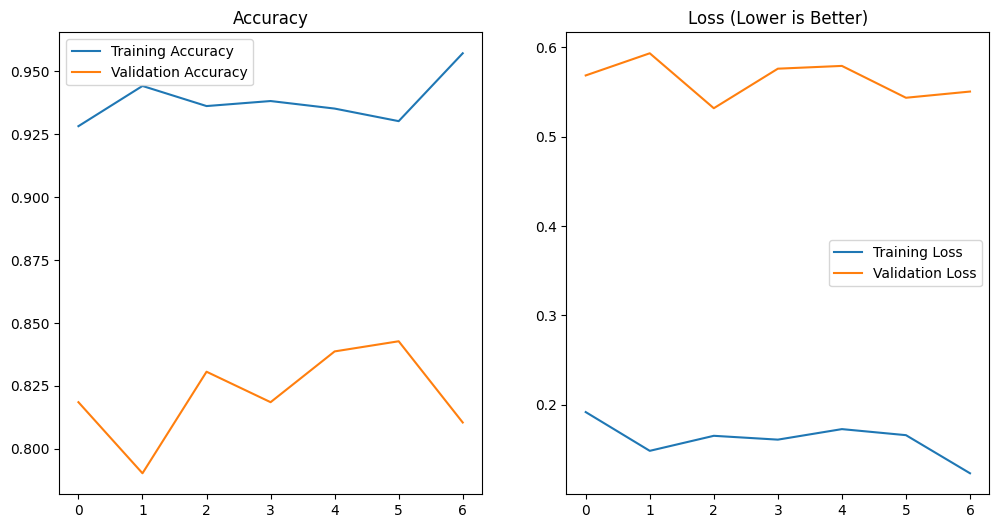

In [ ]:
import matplotlib.pyplot as plt

# 1. Plot the accuracy (Train vs Test)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# 2. Plot the Loss (Train vs Test)
# This will show you exactly where the lines crossed and started getting worse
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss (Lower is Better)')
plt.legend()
plt.show()

In [ ]:
# We evaluate the accuracy and the loss in the test set
scores = model.evaluate(testing_data, steps = len(testing_data), verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 744ms/step - accuracy: 0.8517 - loss: 0.6055
Test loss: 0.5351242423057556
Test accuracy: 0.8467742204666138


In [ ]:
# 1. Calculate Score
loss, accuracy = model.evaluate(testing_data, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 897ms/step - accuracy: 0.8517 - loss: 0.6055
Test Loss: 0.5351
Test Accuracy: 84.68%


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 789ms/step


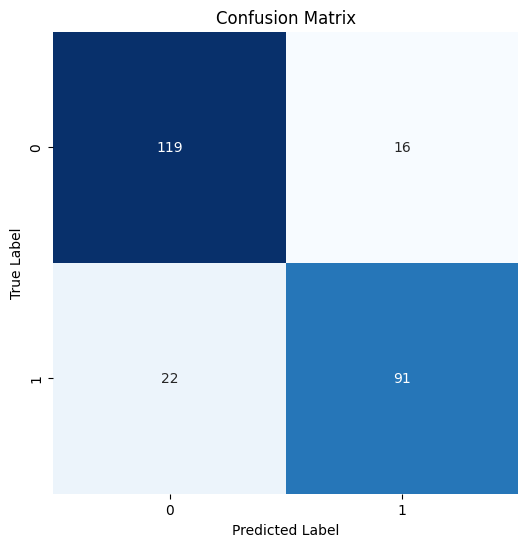

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       135
           1       0.85      0.81      0.83       113

    accuracy                           0.85       248
   macro avg       0.85      0.84      0.84       248
weighted avg       0.85      0.85      0.85       248



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# 1. Get the predictions
# We need to reset the validation generator so it starts from the first image
testing_data.reset()

# Predict raw probabilities (e.g., 0.12, 0.95, 0.88)
predictions = model.predict(testing_data, steps=len(testing_data), verbose=1)

# 2. Convert probabilities to class (0 or 1)
# Since it's binary, if probability > 0.5, it's class 1 (Dog), else class 0 (Cat)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)

# 3. Get the true labels
true_classes = testing_data.classes

# 4. Create the Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# 5. Plot it nicely
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 6. Print the detailed report
print(classification_report(true_classes, predicted_classes))

In [ ]:
from google.colab import drive
import os

# Create a folder for your project (if it doesn't exist)
save_path = '/content/drive/MyDrive/Waste_classification'
if not os.path.exists(save_path):
    os.makedirs(save_path)

#  Save the FINAL model
# This saves the Architecture + Weights + Optimizer state
model.save(os.path.join(save_path, 'recycle_nonrecycle_model.keras'))

print(f"✅ Model successfully saved to: {save_path}")

✅ Model successfully saved to: /content/drive/MyDrive/Waste_classification


In [ ]:
from tensorflow.keras.models import load_model
import os

# Define the path where the model was saved
save_path = '/content/drive/MyDrive/Waste_classification'
model_filename = 'recycle_nonrecycle_model.keras'
full_model_path = os.path.join(save_path, model_filename)


print(f"Model '{model_filename}' loaded successfully as 'best'.")

Model 'recycle_nonrecycle_model.keras' loaded successfully as 'best'.


In [ ]:

# Load the model
best = load_model(full_model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


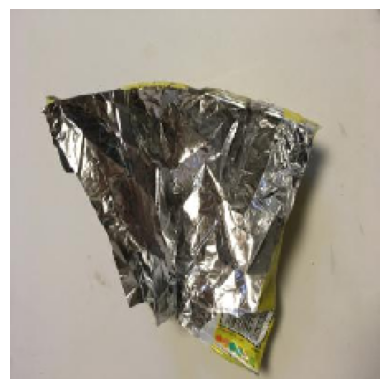

Raw Score: 0.0108
PREDICTION: NON-RECYCLE (98.92%)


In [ ]:
# Replace this string with the path to a test image on your computer
test_image_path = '/content/drive/MyDrive/Testing-photos/trash112.jpg'

# Run the function
predict_image(test_image_path, best)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


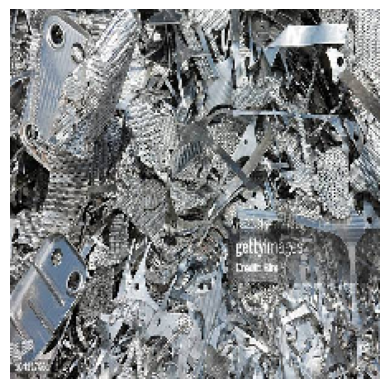

Raw Score: 0.9769
PREDICTION: RECYCLE (97.69%)


In [ ]:
# Replace this string with the path to a test image on your computer
test_image_path1 = '/content/drive/MyDrive/Testing-photos/metal.jpg'

# Run the function
predict_image(test_image_path1, best)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


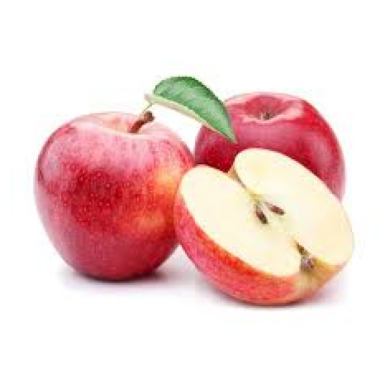

Raw Score: 0.0003
PREDICTION: NON-RECYCLE (99.97%)


In [ ]:
# Replace this string with the path to a test image on your computer
test_image_path1 = '/content/drive/MyDrive/Testing-photos/images.jpg'

# Run the function
predict_image(test_image_path1, best)